In [12]:
# 1. Importação das Bibliotecas
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [13]:
# 2. Carregamento e Preparação dos Dados
print("Carregando e preparando os dados de preços de combustível...")
df = pd.read_csv('gas_prices.csv')

# Preparando os dados para o Prophet (colunas 'ds' e 'y')
# Vamos prever a coluna 'A1'. Você pode alterar para outra coluna se desejar.
df_ts = df[['Date', 'A1']].copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts = df_ts.rename(columns={'Date': 'ds', 'A1': 'y'})

print("Dados preparados para a modelagem.")
print(df_ts)

# Divisão dos dados em conjuntos de treino (95%) e teste (5%)
train_size = int(len(df_ts) * 0.95)
train_df = df_ts.iloc[:train_size]
test_df = df_ts.iloc[train_size:]

Carregando e preparando os dados de preços de combustível...
Dados preparados para a modelagem.
             ds      y
0    1995-01-02  1.127
1    1995-01-09  1.134
2    1995-01-16  1.126
3    1995-01-23  1.132
4    1995-01-30  1.131
...         ...    ...
1356 2020-12-28  2.330
1357 2021-01-04  2.336
1358 2021-01-11  2.403
1359 2021-01-18  2.464
1360 2021-01-25  2.478

[1361 rows x 2 columns]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphhn9t2ko/98ete_7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphhn9t2ko/emncdupc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14676', 'data', 'file=/tmp/tmphhn9t2ko/98ete_7t.json', 'init=/tmp/tmphhn9t2ko/emncdupc.json', 'output', 'file=/tmp/tmphhn9t2ko/prophet_model6uzt1ggb/prophet_model-20251006022822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:28:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Treinando o modelo Prophet...


02:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 0.21


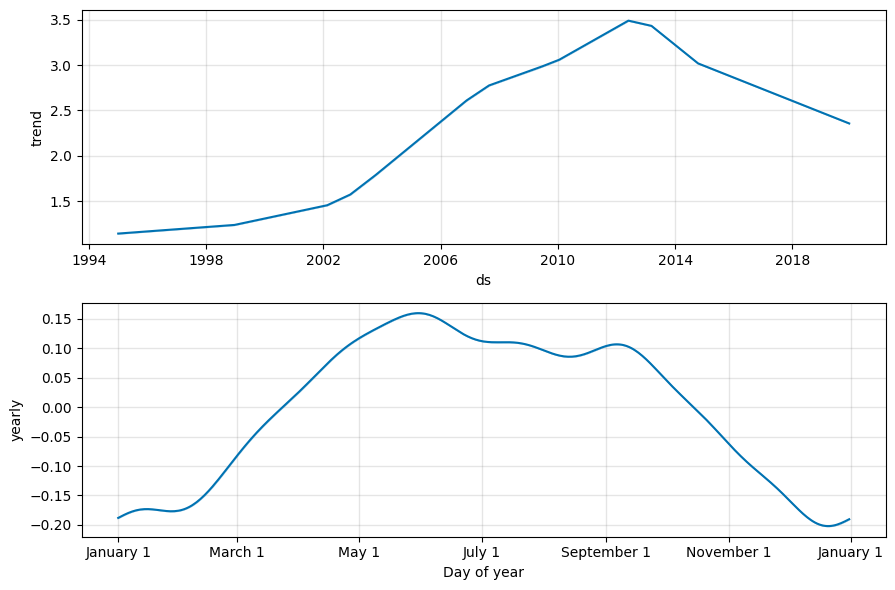

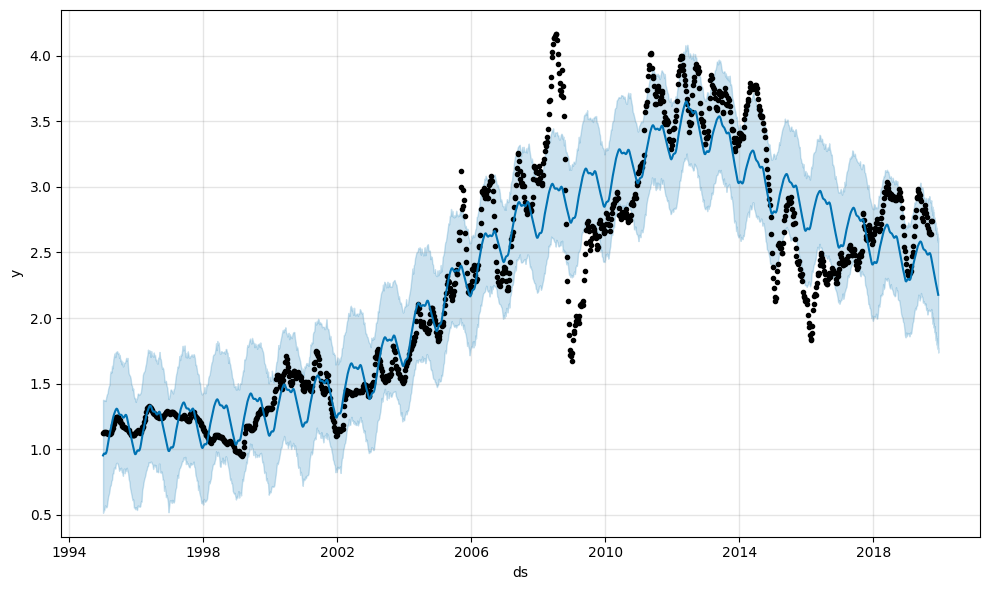

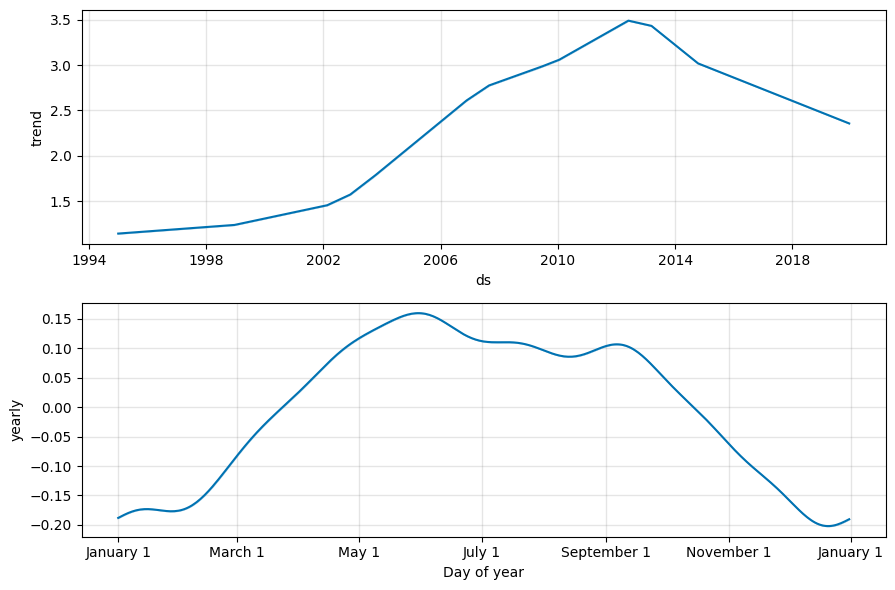

In [14]:
# 3. Modelagem com Facebook Prophet
print("\nTreinando o modelo Prophet...")
prophet_model = Prophet()
prophet_model.fit(train_df)

# Realização de previsões
future = prophet_model.make_future_dataframe(periods=len(test_df))
forecast = prophet_model.predict(future)

# Extração das previsões para o período de teste
prophet_predictions = forecast.iloc[-len(test_df):]['yhat']

# Avaliação do modelo Prophet
prophet_rmse = np.sqrt(mean_squared_error(test_df['y'], prophet_predictions))
print(f"Prophet RMSE: {prophet_rmse:.2f}")

# Geração de gráficos do Prophet
prophet_model.plot(forecast)
prophet_model.plot_components(forecast)


In [17]:
# 4. Modelagem com LSTM
print("\nPreparando dados e treinando o modelo LSTM...")
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_ts['y'].values.reshape(-1,1))

# Separação dos dados de treino
train_data = scaled_data[0:train_size, :]

# Função para criar sequências de dados (janelas de tempo)
def create_dataset(dataset, look_back=60):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 60  # Usaremos 60 dias de histórico para prever o dia seguinte
X_train, y_train = create_dataset(train_data, look_back)

# Remodelagem dos dados para o formato do LSTM [amostras, passos de tempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Construção do modelo LSTM
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
print("Modelo LSTM treinado.")

# Realização de previsões com o LSTM
inputs = scaled_data[len(scaled_data) - len(test_df) - look_back:]
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Avaliação do modelo LSTM
y_test_for_lstm = test_df['y'].values[-len(lstm_predictions):]
lstm_rmse = np.sqrt(mean_squared_error(y_test_for_lstm, lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse:.4f}")


Preparando dados e treinando o modelo LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo LSTM treinado.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
LSTM RMSE: 0.0729



--- Comparação dos Modelos ---
             Modelo  RMSE (Preço A1)
0  Facebook Prophet         0.209147
1              LSTM         0.072950

Gráfico de comparação salvo como 'gas_price_prediction_comparison.png'.


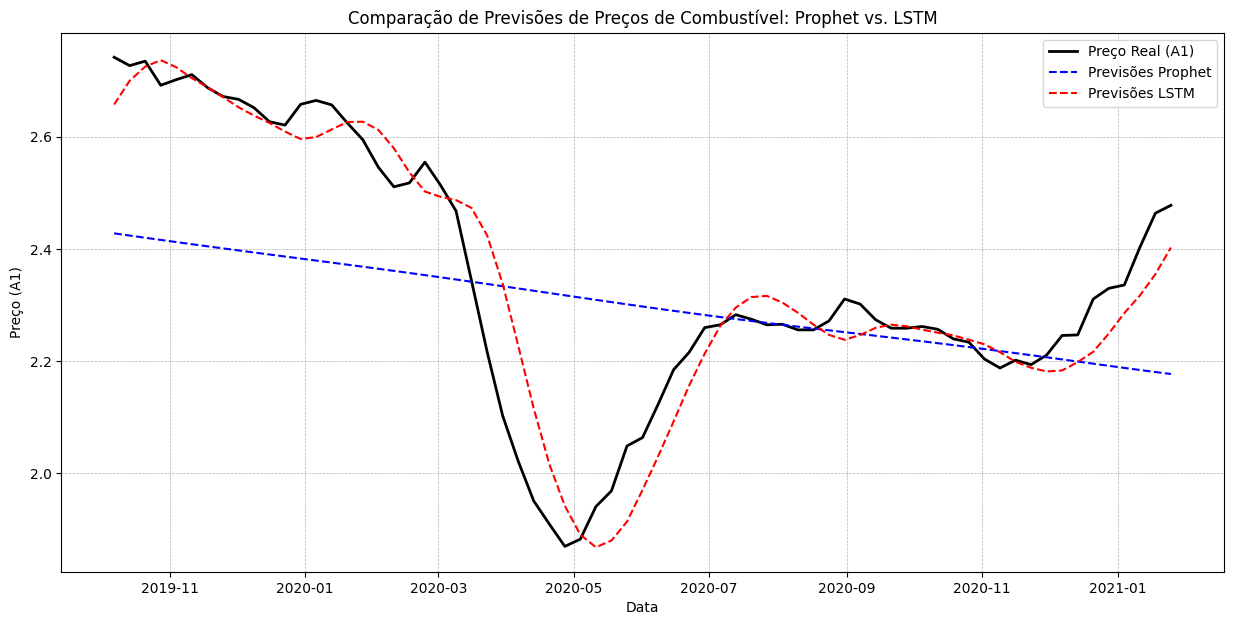

In [18]:
# 5. Comparação dos Resultados
print("\n--- Comparação dos Modelos ---")
results_df = pd.DataFrame({
    'Modelo': ['Facebook Prophet', 'LSTM'],
    'RMSE (Preço A1)': [prophet_rmse, lstm_rmse]
})
print(results_df)

# Geração do gráfico de comparação
plt.figure(figsize=(15, 7))
plt.plot(test_df['ds'], test_df['y'], label='Preço Real (A1)', color='black', lw=2)
plt.plot(test_df['ds'], prophet_predictions, label='Previsões Prophet', color='blue', ls='--')
lstm_dates = test_df['ds'][-len(lstm_predictions):]
plt.plot(lstm_dates, lstm_predictions, label='Previsões LSTM', color='red', ls='--')
plt.title('Comparação de Previsões de Preços de Combustível: Prophet vs. LSTM')
plt.xlabel('Data')
plt.ylabel('Preço (A1)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
print("\nGráfico de comparação salvo como 'gas_price_prediction_comparison.png'.")


# Escolha da métrica

Para a avaliação quantitativa do desempenho dos modelos de previsão, foi selecionada a métrica da Raiz do Erro Quadrático Médio, ou RMSE (Root Mean Squared Error). Esta é uma métrica padrão para aferir a acurácia de modelos de regressão e séries temporais, quantificando a magnitude média dos erros entre os valores previstos e os valores observados.

O cálculo do RMSE é definido pela seguinte expressão matemática:

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^2}$

Onde $y_i$ representa o valor real, $\hat{y_i}$, o valor previsto pelo modelo e $n$ o número total de observações na amostra de teste. O componente central da métrica é a elevação ao quadrado da diferença entre os valores reais e previstos, $(y_{i} - \hat{y_{i}})^2$.

Esta operação matemática confere um peso desproporcionalmente maior aos erros de grande magnitude. A aplicação final da raiz quadrada reverte esta potenciação, fazendo com que o resultado final seja expresso na mesma unidade da variável alvo, o que facilita a interpretação direta da magnitude do erro.

A escolha do RMSE para este projeto justifica-se precisamente por sua sensibilidade a erros expressivos. Em contextos de previsão de preços, falhas em antecipar grandes variações são significativamente mais custosas do que pequenas imprecisões. Portanto, ao penalizar rigorosamente tais desvios, o RMSE favorece a seleção de modelos que demonstram maior robustez e confiabilidade diante de flutuações acentuadas, alinhando-se aos objetivos práticos da análise.

Referência:
https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e